In [17]:
import json

import numpy as np
import torch
from torchvision import models

import shap
from torchvision import datasets, transforms, models

from torch.utils.data import random_split, DataLoader, Subset


In [18]:
val_transform = transforms.Compose([
    transforms.Resize(540),         # 짧은 변을 540으로
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

data_root = '/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_4'
full_dataset = datasets.ImageFolder(root=data_root, transform=None)
# train_ds = ImageFolder(root=data_root, transform=train_transform)
# val_ds   = ImageFolder(root=data_root, transform=val_transform)
style2idx   = full_dataset.class_to_idx.copy()
num_classes = len(style2idx)

In [20]:
n = len(full_dataset)
indices = np.arange(n)
np.random.seed(seed=42)
np.random.shuffle(indices)

n_train = int(0.8 * n)
n_val   = int(0.1 * n)
train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

test_ds  = Subset(datasets.ImageFolder(root=data_root, transform=val_transform),
                  test_idx)

In [21]:
loader_kwargs = dict(
    batch_size=16,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

test_loader  = DataLoader(test_ds,  shuffle=False, **loader_kwargs)


In [23]:
import torch.nn as nn

class ResNet50Head(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.resnet50(pretrained=False)
        in_feats  = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone

        self.drop = nn.Dropout(0.2)
        self.fc1  = nn.Linear(in_feats, 512)
        self.relu = nn.ReLU(inplace=True)
        self.fc2  = nn.Linear(512, 128)
        self.fc3  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)        # → (batch, 2048)
        x = self.drop(x)
        x = self.relu(self.fc1(x))  # → (batch, 1024)
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)             # → (batch, num_classes)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = ResNet50Head(num_classes).to(device)

In [24]:
# Model load 

model_path='/home/work/workspace_ai/Artificlass/real_use_code/best_model_from_folder_pre.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

ResNet50Head(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

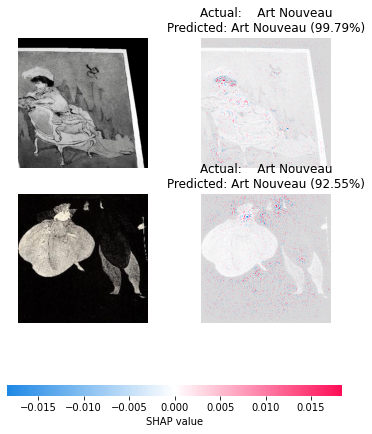

In [13]:
import os
import json
import numpy as np
import torch
from torchvision import models
from PIL import Image
import shap
import torch.nn.functional as F


# 1) 모델 불러오기
from backbone import ResNet50Head  # 실제 정의한 모듈 경로 맞춰주세요
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# data_root = '/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_4'
# full_dataset = datasets.ImageFolder(root=data_root, transform=None)
# # train_ds = ImageFolder(root=data_root, transform=train_transform)
# # val_ds   = ImageFolder(root=data_root, transform=val_transform)
# style2idx   = full_dataset.class_to_idx.copy()
style2idx = {'Art Nouveau': 0, 'Baroque': 1, 'Expressionism': 2, 'Impressionism': 3, 'Post-Impressionism': 4, 'Realism': 5, 'Romantic': 6}
idx2style = {i:s for s,i in style2idx.items()}
num_classes = len(style2idx)
model = ResNet50Head(num_classes).to(device)
model.load_state_dict(torch.load('/home/work/workspace_ai/Artificlass/real_use_code/best_model_from_folder_pre.pth', map_location=device))
model.eval()

# 2) SHAP 입력용 normalize 함수
mean = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
std  = np.array([0.229, 0.224, 0.225]).reshape((1,1,3))
def preprocess(imgs):
    # imgs: numpy (B,H,W,3) in [0,1] or [0,255]
    if imgs.max() > 1.0:
        imgs = imgs / 255.0
    imgs = (imgs - mean) / std
    # B,H,W,3 → B,3,H,W
    return torch.from_numpy(imgs).permute(0,3,1,2).float().to(device)

# 3) 배경용(Background) 데이터 샘플
#    전체 테스트셋에서 랜덤하게 50장 정도 뽑아서 numpy array로 준비
from torchvision.datasets import ImageFolder
from torchvision import transforms

val_tf = transforms.Compose([
    transforms.Resize(540),
    transforms.CenterCrop(512),
    transforms.ToTensor()  # → [0,1], C×H×W
])

ds = ImageFolder(root='/home/work/workspace_ai/Artificlass/data_process/data/augmented_images_4',
                 transform=val_tf)
# 뒤에서 numpy로 바꾸려면 tensor→numpy
bg_indices = np.random.choice(len(ds), size=50, replace=False)
bg_imgs = []
for idx in bg_indices:
    img, _ = ds[idx]                # img: Tensor(3,512,512)
    bg_imgs.append(img.permute(1,2,0).numpy())  # H×W×C
bg_imgs = np.stack(bg_imgs, axis=0)  # (50,H,W,C)

# 4) 설명할 샘플 선택 (예: 2장)
to_explain = []
true_idxs  = []
for idx in [50, 24]:
    img, label = ds[idx]
    to_explain.append(img.permute(1,2,0).numpy())
    true_idxs.append(label)
to_explain = np.stack(to_explain, axis=0)  # (2,H,W,C)
true_idxs  = np.array(true_idxs)

# 5) GradientExplainer 생성
#    두 번째 인자는 ‘모델-출력-전’ 레이어를 지정할 수도 있지만,
#    전체 모델에 대해 입력 그라디언트 기반 설명을 원하면 (model, model.backbone) 처럼 전달
explainer = shap.GradientExplainer(
    (model, model.backbone),       # 또는 (model, model.backbone.layer4)
    preprocess(bg_imgs)            # background as Tensor(50,3,512,512)
)

# 6) SHAP 값 계산
#    ranked_outputs=1 → 가장 높은 클래스에 대한 explanation
shap_values, indexes = explainer.shap_values(
    preprocess(to_explain),       # Tensor(2,3,512,512)
    ranked_outputs=1,
    nsamples=100                   # 조절 가능
)
# 7) 예측 확률 계산
with torch.no_grad():
    logits = model(preprocess(to_explain))      # (B, num_classes)
    probs  = F.softmax(logits, dim=1).cpu().numpy()

idx_np = indexes.cpu().numpy()  # shape (B, 2)


# idx_np = indexes.cpu().numpy()  # shape (B,1) or (B,K)
# index_names = np.array([
#     [ idx2style[int(i)] for i in idx_list ]
#     for idx_list in idx_np
# ])

# 8) 클래스 이름 + 확률 문구 생성
# index_names = np.array([
#     [ f"{idx2style[i]} ({probs[s, i]:.2%})" for i in idx_list ]
#     for s, idx_list in enumerate(idx_np)
# ])

index_names = np.array([
    [ 
      f"Actual:    {idx2style[true_idxs[s]]}\n"
      f"Predicted: {idx2style[int(idx_np[s,0])]} "
      f"({probs[s,int(idx_np[s,0])]:.2%})"
    ]
    for s in range(len(to_explain))
])

# 8) 시각화
#    shap_values: list of arrays [ for each output-class: (2,3,512,512) ]
#    to_explain:      (2,512,512,3)
#    index_names:     (2,1)
shap_values = [ sv.transpose(0,2,3,1) for sv in shap_values ]
shap.image_plot(shap_values, to_explain, index_names)


# ROC curve

The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=None`.


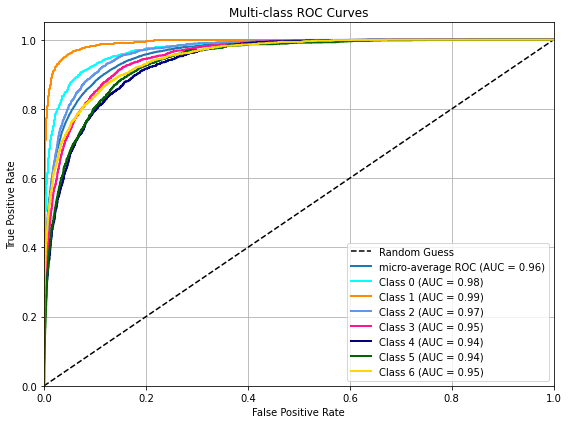

In [27]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

# 1) 전체 Dataset 정의 (transform=val_tf)
full_ds = ImageFolder(root=data_root, transform=val_transform)

# 2) train/val/test split (seed=42)
n = len(full_ds)
indices = np.arange(n)
np.random.seed(42)
np.random.shuffle(indices)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

# 3) 테스트 전용 Subset
test_ds = Subset(full_ds, test_idx)
test_loader = DataLoader(test_ds, shuffle=False, **loader_kwargs)
num_classes = len(style2idx)
model = ResNet50Head(num_classes).to(device)
model.load_state_dict(torch.load('/home/work/workspace_ai/best_model_from_folder.pth', map_location=device))
# model.eval()
model.eval()

# — 2) test set 전체에 대해 예측 확률과 실제 레이블 수집 —
y_true = []
y_score = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        y_score.append(probs)
        y_true.append(labels.numpy())

y_score = np.vstack(y_score)   # shape (N_samples, N_classes)
y_true  = np.concatenate(y_true)  # shape (N_samples,)

# — 3) 레이블 이진화 (one-hot) —
n_classes = y_score.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))  # shape (N, n_classes)

# — 4) 클래스별 ROC / AUC 계산 —
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# — 5) Micro-average ROC —
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# — 6) Plotting —
plt.figure(figsize=(8, 6))
# 대각선 (무작위 분류기)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# micro-average
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
         linewidth=2)

# 클래스별
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy', 'darkgreen', 'gold'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Heatmap

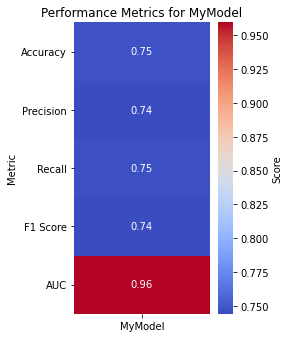

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# ─────────────────────────────────────────────────────────────
# 0) 모델, test_loader, device 준비 (이미 정의된 변수)
# ─────────────────────────────────────────────────────────────\

# 1) 전체 Dataset 정의 (transform=val_tf)
full_ds = ImageFolder(root=data_root, transform=val_transform)

# 2) train/val/test split (seed=42)
n = len(full_ds)
indices = np.arange(n)
np.random.seed(42)
np.random.shuffle(indices)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

# 3) 테스트 전용 Subset
test_ds = Subset(full_ds, test_idx)
test_loader = DataLoader(test_ds, shuffle=False, **loader_kwargs)
num_classes = len(style2idx)
model = ResNet50Head(num_classes).to(device)
model.load_state_dict(torch.load('/home/work/workspace_ai/best_model_from_folder.pth', map_location=device))
# model.eval()
# model.eval()

# model: 학습된 ResNet50Head 등
# test_loader: DataLoader(test_ds, batch_size=..., shuffle=False)
# device: 'cuda' or 'cpu'
model.eval()

# ─────────────────────────────────────────────────────────────
# 1) test set 돌면서 y_true, y_pred, y_prob 수집
# ─────────────────────────────────────────────────────────────
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        preds  = np.argmax(probs, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.vstack(y_prob)  # shape (N_samples, num_classes)

# ─────────────────────────────────────────────────────────────
# 2) 주요 지표 계산 (macro average)
# ─────────────────────────────────────────────────────────────
acc   = accuracy_score(y_true, y_pred)
prec  = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec   = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1    = f1_score(y_true, y_pred, average='macro', zero_division=0)
# 다중 클래스 AUC: OVR, macro
auc   = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')

metrics = {
    'Accuracy':  acc,
    'Precision': prec,
    'Recall':    rec,
    'F1 Score':  f1,
    'AUC':       auc
}

# ─────────────────────────────────────────────────────────────
# 3) DataFrame으로 변환 & 히트맵 그리기
# ─────────────────────────────────────────────────────────────
model_name = 'ResNet_Non_pretrained_3'  # 원하는 이름으로 바꿔 주세요

df = pd.DataFrame(metrics, index=[model_name]).T
#              MyModel
# Accuracy         0.89
# Precision        0.87
# ...

plt.figure(figsize=(4, 5))
sns.heatmap(
    df,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar_kws={'label': 'Score'}
)
plt.title(f'Performance Metrics for {model_name}')
plt.ylabel('Metric')
plt.xlabel(' ')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=None`.
The parameter 'pretrained' is deprecated, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=None`.


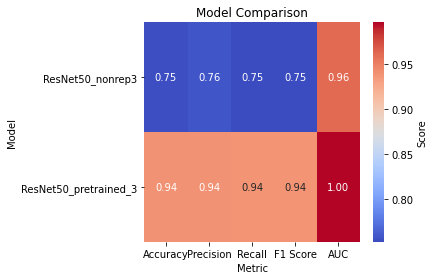

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from backbone import ResNet50Head
# from efficientnet import EfficientNetB0Head

# ─────────────────────────────────────────────────────────────
# 0) 모델, test_loader, device 준비 (이미 정의된 변수)
# ─────────────────────────────────────────────────────────────\

# 1) 전체 Dataset 정의 (transform=val_tf)
full_ds = ImageFolder(root=data_root, transform=val_transform)

# 2) train/val/test split (seed=42)
n = len(full_ds)
indices = np.arange(n)
np.random.seed(42)
np.random.shuffle(indices)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

# 3) 테스트 전용 Subset
test_ds = Subset(full_ds, test_idx)
test_loader = DataLoader(test_ds, shuffle=False, **loader_kwargs)
num_classes = len(style2idx)
# model = ResNet50Head(num_classes).to(device)
# model.load_state_dict(torch.load('/home/work/workspace_ai/best_model_from_folder.pth', map_location=device))
# # model.eval()
# # model.eval()

# # model: 학습된 ResNet50Head 등
# # test_loader: DataLoader(test_ds, batch_size=..., shuffle=False)
# # device: 'cuda' or 'cpu'
# model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2) 모델 정의 리스트
model_info = {
    'ResNet50_nonrep3':      {'cls': ResNet50Head,     'ckpt':'/home/work/workspace_ai/best_model_from_folder.pth'},
    'ResNet50_pretrained_3':{'cls': ResNet50Head,     'ckpt':'/home/work/workspace_ai/Artificlass/real_use_code/best_model_from_folder_pre.pth'},
    # 'ResNet50_nonrep4':      {'cls': ResNet50Head,     'ckpt':'best_resnet.pth'},
    # 'ResNet50_pretrained_4':{'cls': ResNet50Head,     'ckpt':'best_resnet_pre_4.pth'},
    # 'EfficientNetB0':{'cls': EfficientNetB0Head,'ckpt':'best_effnet.pth'}
}

# 3) 모델별 성능 수집
all_metrics = {}
for name, info in model_info.items():
    model = info['cls'](num_classes=len(full_ds.classes)).to(device)
    model.load_state_dict(torch.load(info['ckpt'], map_location=device))
    model.eval()

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs  = F.softmax(logits, dim=1).cpu().numpy()
            preds  = np.argmax(probs, axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.vstack(y_prob)

    metrics = {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall':    recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1 Score':  f1_score(y_true, y_pred, average='macro', zero_division=0),
        'AUC':       roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    }
    all_metrics[name] = metrics

# 4) 히트맵
df = pd.DataFrame(all_metrics).T
plt.figure(figsize=(6,4))
sns.heatmap(df, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label':'Score'})
plt.title('Model Comparison')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
